In [1]:
import os
import numpy as np
from typing import NamedTuple, List
from argparse import Namespace
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from data_manager import SinGanOne_Dataset
from models import SinGanOneModel
from functions import torch2np
from config import post_config
from train import SinGanOneTrainer
from train_results import *
%matplotlib notebook

In [2]:
opt = Namespace()
opt.reals_dir = os.path.join(os.getcwd(), 'Input', 'Images')
opt.real_name = 'nature5.jpg'
opt.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt.plotting = False
opt.seed = 42
opt.top_res_dir = 'Output'
opt.top_models_dir = 'TrainedModels'
opt.min_size = 25
opt.max_size = 250
opt.batch_size = 3
# opt.batch_size = 1
opt.num_workers = 1
opt.scale_factor = 0.75
opt.ker_size = 3
opt.num_layer = 5
opt.niter = 2000
# opt.niter = 6000
opt.alpha = 10
opt.nfc = 32
opt.min_nfc = 32
opt.padd_size = 0
opt.netG = ''
opt.netD = ''
opt.lambda_grad = 0.1
opt.alpha = 10
opt.lr_g = 0.0005
opt.lr_d = 0.0005
opt.beta1 = 0.5
opt.gamma = 0.1
opt
opt = post_config(opt)
opt

Namespace(alpha=10, batch_size=3, beta1=0.5, device=device(type='cpu'), gamma=0.1, ker_size=3, lambda_grad=0.1, lr_d=0.0005, lr_g=0.0005, max_size=250, min_nfc=32, min_nfc_init=32, min_size=25, model_dir='TrainedModels/nature5/scale_factor=0.75,alpha=10,min_size=25,max_size=250/batch_size=3,niter=2000', netD='', netG='', nfc=32, nfc_init=32, niter=2000, num_layer=5, num_workers=1, pad_image=5, pad_noise=5, padd_size=0, plotting=False, real_name='nature5.jpg', reals_dir='/home/manor/singan/SinGanOne/Input/Images', res_dir='Output/nature5', scale_factor=0.75, seed=42, top_models_dir='TrainedModels', top_res_dir='Output')

In [3]:
curr_scale = 0

In [4]:
singanone = SinGanOneModel(curr_scale, opt)
print(singanone)

|--------------------Generator--------------------|
|-------------------------------------------------|
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm)

In [5]:
ds = SinGanOne_Dataset(opt, curr_scale)
dl = DataLoader(ds,opt.batch_size, shuffle=False, num_workers=opt.num_workers)

In [6]:
def plot_single_batch(batch:List[torch.Tensor]):
    real    = batch[0]
    z_rec   = batch[1]
    prev    = batch[2]
    z_prev  = batch[3]
    noise   = batch[4]
    
    fig, axes = plt.subplots(5,1, figsize=(8,8))
    fig.tight_layout()
    
    axes[0].imshow(torch2np(make_grid(real)))
    axes[1].imshow(torch2np(make_grid(z_rec)))
    axes[2].imshow(torch2np(make_grid(prev)))
    axes[3].imshow(torch2np(make_grid(z_prev)))
    axes[4].imshow(torch2np(make_grid(noise)))
    
    axes[0].set_title(f'Real')
    axes[1].set_title(f'Z Reconstruction')
    axes[2].set_title(f'Prev')
    axes[3].set_title(f'Z Prev')
    axes[4].set_title(f'Noise')
    plt.show()

In [7]:
singanone_trainer = SinGanOneTrainer(singanone, opt.niter, opt.device, opt.lambda_grad, opt.alpha)
# fitresult = singanone_trainer.fit(dl, post_epoch_fn=plot_single_batch)
fitresult = singanone_trainer.fit(dl)

Avg. ErrD(r)=1.102 | Avg. ErrD(f)=-1.069 | Avg. Penalty=0.796 | Avg. ErrD(total)=-1.375 | Avg. ErrG=1.100 | Avg. RecLoss=0.099: 100%|██████████| 667/667 [07:00<00:00,  1.59it/s]


In [8]:
def plot_errors(fitresult:FitResult):
    fig, ax = plt.subplots()
    ax.plot(fitresult.errD_reals, label='errD (real)')
    ax.plot(fitresult.errD_fakes, label='errD (fake)')
    ax.plot(fitresult.gradPenalties, label='Gradient Penalty')
    ax.plot(fitresult.errDs, label='errD (total)')
    ax.plot(fitresult.errGs, label='errG')
    ax.plot(fitresult.recLosses, label='Reconstruction Loss')
    fig.legend()
    plt.show()

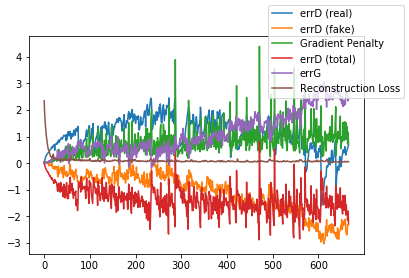

In [9]:
plot_errors(fitresult)

In [10]:
def imshow_fitresult(fitresult:FitResult):
    
    rows1, cols1 = int(np.ceil(np.sqrt(len(fitresult.fake_images)))), int(np.floor(np.sqrt(len(fitresult.fake_images))))
    rows2, cols2 = int(np.ceil(np.sqrt(len(fitresult.G_z_images)))), int(np.floor(np.sqrt(len(fitresult.G_z_images))))
    rows3, cols3 = int(np.ceil(np.sqrt(len(fitresult.D_fakes)))), int(np.floor(np.sqrt(len(fitresult.D_fakes))))
    rows4, cols4 = int(np.ceil(np.sqrt(len(fitresult.D_reals)))), int(np.floor(np.sqrt(len(fitresult.D_reals))))
    
    fig1, axes1 = plt.subplots(rows1, cols1, figsize=(8,8))
    axes1 = axes1.flat
    fig1.suptitle('Fake Images')
    fig2, axes2 = plt.subplots(rows2, cols2, figsize=(8,8))
    axes2 = axes2.flat
    fig2.suptitle('G(Z Reconstruction) Images')
    fig3, axes3 = plt.subplots(rows3, cols3, figsize=(8,8))
    axes3 = axes3.flat
    fig3.suptitle('Disc(fakes) Maps')
    fig4, axes4 = plt.subplots(rows4, cols4, figsize=(8,8))
    axes4 = axes4.flat    
    fig4.suptitle('Disc(reals) Maps')
    
    for i, (fake_ims, g_z_ims, d_fakes, d_reals) in enumerate(zip(fitresult.fake_images,
                                                                  fitresult.G_z_images,
                                                                  fitresult.D_fakes,
                                                                  fitresult.D_reals)):
        axes1[i].imshow(torch2np(make_grid(fake_ims)))
        axes1[i].set_title(f'{i}')
        axes2[i].imshow(torch2np(make_grid(g_z_ims)))
        axes2[i].set_title(f'{i}')        
        axes3[i].imshow(torch2np(make_grid(d_fakes)))
        axes3[i].set_title(f'{i}')
        axes4[i].imshow(torch2np(make_grid(d_reals)))
        axes4[i].set_title(f'{i}')
        
    plt.show()
        

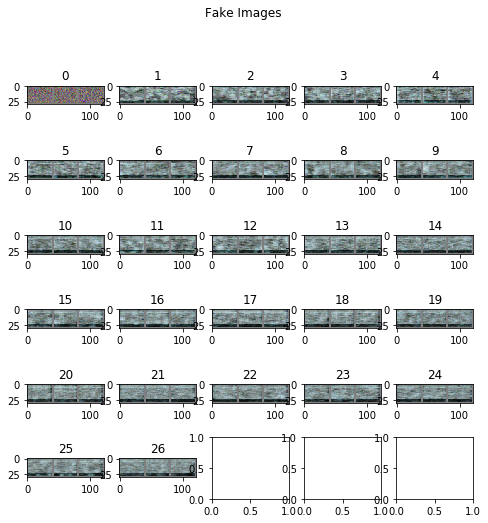

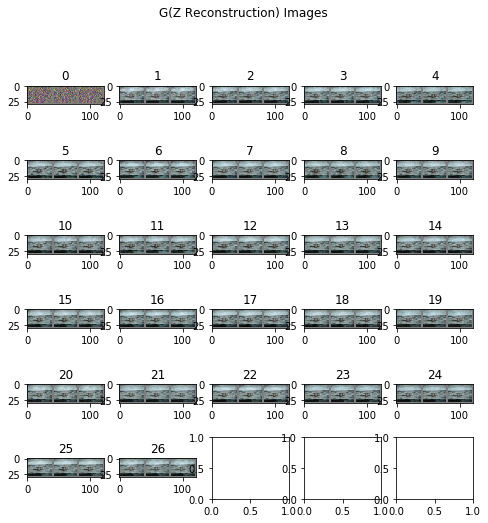

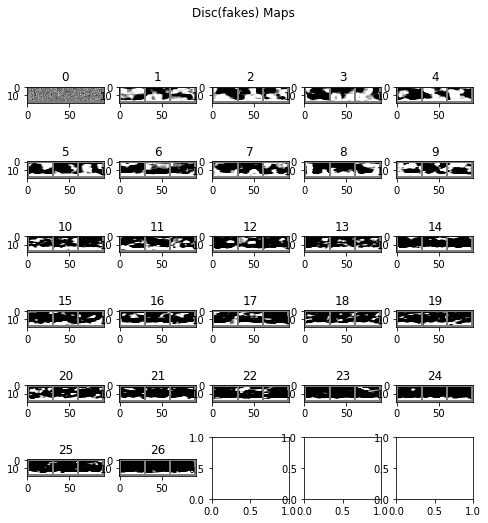

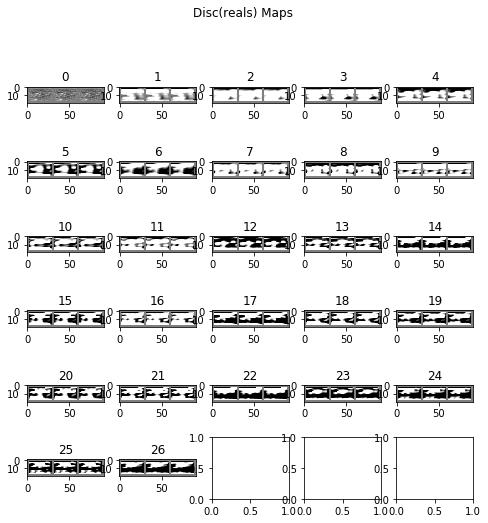

In [11]:
imshow_fitresult(fitresult)